In [1]:
import numpy as np
import ndio.remote.neurodata as ND
from datetime import datetime

startTime = datetime.now()

nd = ND()

token = 'bock11'
channel = 'image'
res = 7

pixel_dim = 0.004*(2**res)*0.004*(2**res)*0.045  #can get from LIMS
imsize = nd.get_image_size(token, resolution=res)
offset = nd.get_image_offset(token, resolution=res)

In [2]:
voxels = (imsize[0]-offset[0])*(imsize[1]-offset[1])*(imsize[2]-offset[2])
print 'Number of voxels at scale {}: {}'.format(res, '%.02e' % (voxels))
print 'Number of voxels at scale {}: {}'.format(0, '%.02e' % (voxels*2**res*2**res))
print 'Number of voxels at scale {}: {}'.format(1, '%.02e' % (voxels*2**(res-1)*2**(res-1)))


Number of voxels at scale 7: 1.23e+09
Number of voxels at scale 0: 2.01e+13
Number of voxels at scale 1: 5.03e+12


In [3]:
import time
t = time.time()
nd = ND(chunk_threshold=2e9)
im = nd.get_cutout(token, channel, offset[0], imsize[0], offset[1], imsize[1], offset[2], imsize[2], res)
print time.time()-t

252.194504023


In [4]:
seg_pixels = sum(sum(sum(im > 0)))
seg_volume =  voxels * pixel_dim
print 'Non-zero pixels {} %'.format(np.round(1.0*seg_pixels/voxels*100))
print 'Voxels to process: ' + '%.02e' % (seg_pixels * 2**(res-1) * 2**(res-1))
print 'Volume to process: ' + str(np.round(seg_volume)) + ' um^3'

Non-zero pixels 52.0 %
Voxels to process: 2.60e+12
Volume to process: 14473890.0 um^3


In [5]:
t = time.time()
ids_mp4 = nd.get_ramon_ids('MP4merged','annotation')
print time.time()-t

# Not currently used 
ids_lp4 = nd.get_ramon_ids('LP4merged','annotation')
print time.time()-t


1192.59872699
1436.29148602


In [6]:
density_nonblank = 1.0*len(ids_mp4)/(seg_volume*1.0*seg_pixels/voxels)
density_all = 1.0*len(ids_mp4)/seg_volume
print 'Number of synapses in LP4 is: {}'.format(len(ids_lp4))
print 'Number of synapses in MP4 is: {}'.format(len(ids_mp4))
print 'Density ignoring zero valued pixels is {}.'.format(round(density_nonblank,2))
print 'Density with all pixels is {}.'.format(round(density_all,2))

Number of synapses in LP4 is: 2423759
Number of synapses in MP4 is: 11668787
Density ignoring zero valued pixels is 1.56.
Density with all pixels is 0.81.


In [7]:
import ndparse as ndp
import ndio.ramon as ramon

upload_truth = False
if upload_truth:
    r = ramon.RAMONSynapse()
    ndpa = ndp.annotate()
    ndpa.put_ramon_volume('bock11_parse', 'eval1', 'bock11_x22000-23000_y22000-23000_z3000-3050_r1_anno.nii.gz', r, 22000,
                           22000, 3000, resolution=1, conncomp=1, remote='neurodata')


In [8]:
res = 1
xbound = [22000, 23000]
ybound = [22000, 23000]
zbound = [3000, 3050]

# Get image data
im = nd.get_cutout(token, channel, xbound[0], xbound[1], ybound[0], ybound[1], zbound[0], zbound[1], res)

detect = nd.get_cutout('MP4merged', 'annotation', xbound[0], xbound[1], ybound[0], ybound[1], zbound[0], zbound[1], res)
truth = nd.get_cutout('bock11_parse', 'eval1', xbound[0], xbound[1], ybound[0], ybound[1], zbound[0], zbound[1], res)

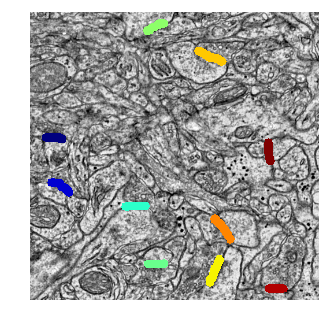

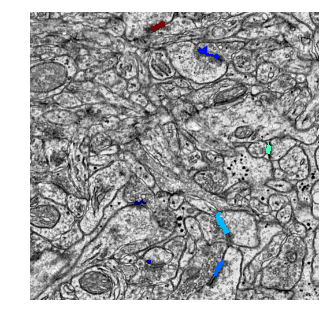

In [9]:
%matplotlib inline  
ndp.plot(im[200:700,200:700,:],truth[200:700,200:700,:],slice = 9, save_plot='ndp_bock_truth.png')
ndp.plot(im[200:700,200:700,:],detect[200:700,200:700,:], slice = 9, save_plot='ndp_bock_detect.png')

#ndp.assess.save_movie(im, detect, outFile='test_detect.mp4')


In [10]:
import ndparse as ndp
precision, recall, f1 = ndp.assess.pr_object(detect, truth)

print 'Precision: {}, Recall: {}, and f1: {} for this evaluation volume'.format(round(precision,2), round(recall,2), round(f1,2))

0.440329218107
0.68152866242
0.535
Precision: 0.44, Recall: 0.68, and f1: 0.54 for this evaluation volume
